# Comparing methods of pattern matching

## Install Dependencies

In [ ]:
!pip install matplotlib kdbai_client -q
%pip install kaggle
!dnf install unzip

## 1. Download Data

### Dataset Overview

https://www.kaggle.com/datasets/caesarlupum/benckmark-anomaly-timeseries-skab/data

### Download Data

In [ ]:
import kaggle

!kaggle datasets list -s [benckmark-anomaly-timeseries-skab]
!kaggle datasets download caesarlupum/benckmark-anomaly-timeseries-skab
!unzip benckmark-anomaly-timeseries-skab.zip

### Load Data & Cleanup

Let's do some preparation on the dataset to clean it up. We will remove duplicates, drop  irrelevant columns and handle missing data.

In [1]:
import pandas as pd

df = pd.read_csv("alldata_skab.csv")
df = df.drop_duplicates()  # Drop duplicates
df = df.dropna(subset=['anomaly'])
df

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
8830,2020-02-08 16:06:48,0.213851,0.267607,2.907460,-0.273216,88.4133,29.3633,239.732,126.6780,0.0,0.0
8833,2020-02-08 16:06:49,0.211527,0.265487,2.330750,0.054711,88.4742,29.3605,234.854,126.3240,0.0,0.0
8835,2020-02-08 16:06:50,0.213755,0.267392,1.989040,0.054711,88.4571,29.3605,211.448,126.6780,0.0,0.0
8837,2020-02-08 16:06:51,0.213065,0.264206,2.558080,0.054711,88.5919,29.3601,228.258,126.3240,0.0,0.0
8839,2020-02-08 16:06:52,0.214307,0.268252,2.024300,0.382638,88.4990,29.3666,228.905,126.6780,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
46618,2020-03-09 17:14:04,0.026853,0.038926,0.740614,0.054711,69.6371,24.1045,237.276,32.0451,0.0,0.0
46619,2020-03-09 17:14:05,0.027067,0.038430,0.988875,0.054711,69.6731,24.1046,230.729,32.9562,0.0,0.0
46620,2020-03-09 17:14:07,0.027582,0.038836,0.588439,0.054711,69.6959,24.1020,233.443,32.0000,0.0,0.0
46621,2020-03-09 17:14:08,0.027406,0.038133,0.989732,-0.273216,69.6293,24.1020,238.930,32.0000,0.0,0.0


This dataset has 8 sensor columns - for the purposes of this example we will only select the `Volume Flow RateRMS`.

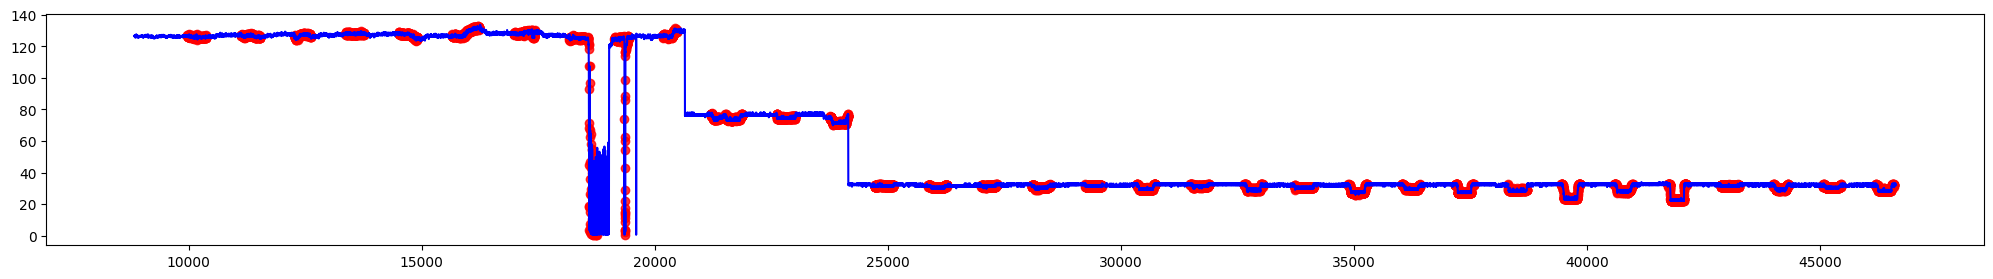

In [2]:
import matplotlib.pyplot as plot

# Type conversions, object to datetime
df["datetime"] = pd.to_datetime(df["datetime"])

# Extract the readings from the BROKEN state of the pump
broken = df[df["anomaly"] == 1.0]
# Extract the names of the numerical columns
df1 = df[["datetime", "Volume Flow RateRMS"]]

# Plot time series for each sensor with BROKEN state marked with X in red color
plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="red", alpha= 0.8, markersize=6)
plot.plot(df["Volume Flow RateRMS"], color="blue")
plot.show()

## 2. Create Embedding

Next, let's create embeddings for these values. To do this we use a combination of windowing and normalizing the data. We have chosen a simple approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise.

### Windowing

The code below divides the original time series data into overlapping windows, with each window containing a specified number of rows and a step size determining how they are shifted along the timeline. It also extracts a timestamp from each window as we will want to store this as metadata.

In [3]:
# Set the window size (number of rows in each window)
window_size = 30
step_size = 10

# Initialize empty lists to store results
start_times = []
end_times = []
vfr_values = []

# Iterate through the DataFrame with the specified step size
for i in range(0, len(df) - window_size + 1, step_size):
    window = df.iloc[i : i + window_size]
    start_time = window["datetime"].iloc[0]
    end_time = window["datetime"].iloc[-1]
    values_in_window = window["Volume Flow RateRMS"].tolist()
    start_times.append(start_time)
    end_times.append(end_time)
    vfr_values.append(values_in_window)

# Create a new DataFrame from the collected data
result_data = {"startTime": start_times, "endTime": end_times, "vectors": vfr_values}
result_df = pd.DataFrame(result_data)


# Print the resulting DataFrame
result_df

,startTime,endTime,vectors
0,2020-02-08 16:06:48,2020-02-08 16:07:19,"[126.678, 126.324, 126.678, 126.324, 126.678, ..."
1,2020-02-08 16:06:59,2020-02-08 16:07:29,"[125.65, 127.0, 126.324, 126.0, 126.678, 126.3..."
2,2020-02-08 16:07:09,2020-02-08 16:07:40,"[126.0, 126.678, 127.678, 126.65, 126.0, 126.6..."
3,2020-02-08 16:07:20,2020-02-08 16:07:50,"[127.0, 126.324, 126.678, 127.0, 125.65, 125.6..."
4,2020-02-08 16:07:30,2020-02-08 16:08:01,"[126.0, 126.0, 126.0, 126.0, 126.678, 126.324,..."
...,...,...,...
3701,2020-03-09 17:12:53,2020-03-09 17:13:24,"[31.9562, 31.0451, 32.0, 32.0, 31.9562, 31.091..."
3702,2020-03-09 17:13:04,2020-03-09 17:13:35,"[31.9562, 31.0916, 32.9137, 31.0451, 32.0451, ..."
3703,2020-03-09 17:13:15,2020-03-09 17:13:45,"[32.0, 32.0, 32.0451, 32.9562, 32.0, 32.0, 32...."
3704,2020-03-09 17:13:25,2020-03-09 17:13:56,"[32.0, 31.9562, 31.0451, 32.0, 32.0, 32.9137, ..."


### Normalization & Scaling

Next, we perform manual normalization of sensor values within each time-based window. This ensures that the sensor values are scaled uniformly between 0 and 1 which is better for further analysis. Additionally, the DataFrame's index is reset to maintain a clean and continuous row numbering.


In [4]:
# Find the minimum and maximum values for the entire DataFrame
min_value = result_df["vectors"].apply(min).min()
max_value = result_df["vectors"].apply(max).max()

# Normalize the "vectors" column
result_df["vectors"] = result_df["vectors"].apply(
    lambda x: [(v - min_value) / (max_value - min_value) for v in x]
)

# Print the resulting DataFrame
result_df


,startTime,endTime,vectors
0,2020-02-08 16:06:48,2020-02-08 16:07:19,"[0.9473456846986891, 0.9446866793325459, 0.947..."
1,2020-02-08 16:06:59,2020-02-08 16:07:29,"[0.9396240532964427, 0.9497643279978364, 0.944..."
2,2020-02-08 16:07:09,2020-02-08 16:07:40,"[0.9422530134042114, 0.9473456846986891, 0.954..."
3,2020-02-08 16:07:20,2020-02-08 16:07:50,"[0.9497643279978364, 0.9446866793325459, 0.947..."
4,2020-02-08 16:07:30,2020-02-08 16:08:01,"[0.9422530134042114, 0.9422530134042114, 0.942..."
...,...,...,...
3701,2020-03-09 17:12:53,2020-03-09 17:13:24,"[0.2358604460242642, 0.2290168872980125, 0.236..."
3702,2020-03-09 17:13:04,2020-03-09 17:13:35,"[0.2358604460242642, 0.22936616342661606, 0.24..."
3703,2020-03-09 17:13:15,2020-03-09 17:13:45,"[0.23618944160346497, 0.23618944160346497, 0.2..."
3704,2020-03-09 17:13:25,2020-03-09 17:13:56,"[0.23618944160346497, 0.2358604460242642, 0.22..."


## 3. Store Embeddings in KDB.AI 

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session`. Enter the session URL endpoint and API key details from your KDB.AI Cloud portal below.

In [ ]:
import kdbai_client as kdbai
from getpass import getpass

KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have three colums: startTime, endTime, vectors.

In [ ]:
sensor_schema = {
    "columns": [
        {
            "name": "startTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "endTime",
            "pytype": "datetime64[ns]",
        },
        {
            "name": "vectors",
            "vectorIndex": {"dims": window_size, "metric": "L2", "type": "hnsw"},
        },
    ]
}

### Create and Save Table

In [ ]:
table1 = session.create_table("sensor", sensor_schema)
#table1 = session.table("sensor")
#table1.drop()

### Add Embeddings to Table

In [ ]:
table1.insert(result_df)

## 4. Query 

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

We can use `query` to query data from the table.


In [ ]:
table1.query()

## 5. Pattern Matching

Now our data is loaded successfully, we can perform pattern matching on our historical sensor data using KDB.AI `search`. 

### Example Pattern to Query 

The first step is to select a pattern that will be used to query. We chose by selecting a start time, then filtering to get the vector's values for that record and store in a variable called `query_vector`. Any pattern could be selected here.

The resulting query pattern is also displayed as a line plot for visual inspection and analysis.

In [ ]:
## Select historical pattern
random_start_time = pd.to_datetime("2020-02-08 16:50:41")

# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == random_start_time][
    "vectors"
].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == random_start_time]
Q_df = df[(df["datetime"] >= df_query_times.iloc[0]["startTime"]) & (df["datetime"] <= df_query_times.iloc[0]["endTime"])]

# Create a line plot
plot.figure(figsize=(15, 6))
plot.plot(Q_df["datetime"], Q_df["Volume Flow RateRMS"], marker="o", linestyle="-")
plot.xlabel("datetime")
plot.ylabel("Value")
plot.title("Query Pattern")
plot.grid(True)
plot.xticks(rotation=45)  # Rotate x-axis labels for readability

type(query_vector)

In [ ]:
# Plot time series for each sensor with BROKEN state marked with X in red color
plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="lightgrey", markersize=12)
plot.plot(df["Volume Flow RateRMS"], color="blue")
plot.plot(Q_df["Volume Flow RateRMS"], color="red", linewidth=7.0, alpha=0.5)
plot.show()

### Search Based on Example Pattern

Using the embeddings we extracted above in `query_vector` for a random time series pattern, we can search to get the five nearest neighbors using KDB.AI.

In a real life scenario, the example pattern could be some real time data as selected by a machine operator or engineer to pinpoint instances of unusual behavior such as spikes, drops, or recurring trends.

In [ ]:
result = table1.search(query_vector, n=5)
result[0]

The results returned from `table.search` show the closest matches along with value of nearest neighbor distances `nn_distance`. This is helpful to keep in for visulization purposes so we can compare how similar it is to the matches found.

The first result is an exact match as the example pattern we chose was from the existing dataset. 

### Visualize Results

Let's plot these neighbors overlayed with each other on a chart. This is useful for visualizing and analyzing time series data patterns and their relationships.

The code snippet below performs a time-based pattern matching and visualization process, calculating time differences, assiging labels to patterns, and then plotting these patterns with legends to distinguish and display them.

In [ ]:
df1 = df
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    mask = (df1["datetime"] >= row["startTime"]) & (df1["datetime"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["datetime"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    label_counter += 1  # Increment the label counter
    result_list.append(filtered_df)

# Concatenate the results into a new DataFrame
result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")
fig, ax = plot.subplots(figsize=(15, 6))

for name, group in groups:
    ax.plot(
        group["time_difference"], group["Volume Flow RateRMS"], marker="o", label=f"NN {name}"
    )

ax.set_xlabel("Time Difference")
ax.set_ylabel("Sensor Values")
ax.legend(title="Neighbors")
plot.title("Pattern Matches")
plot.grid(True)
plot.show()

In [ ]:
q_res = result[0]
result_list1 = {}
label_counter1=1
df2 = df[['datetime','Volume Flow RateRMS']]

for i in q_res.index:
    mask = (df2['datetime'] >= q_res.loc[i]['startTime']) & (df2['datetime'] <= q_res.loc[i]['endTime'])
    res = df2.loc[mask]
    result_list1[label_counter1] = pd.DataFrame(res)
    label_counter1 +=1

result_list1

    
plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="lightgrey", markersize=12)
plot.plot(df["Volume Flow RateRMS"], color="blue", alpha = 0.5)
plot.plot(Q_df["Volume Flow RateRMS"], color="red", linewidth=7.0, alpha=0.5)

for j in range(2,1+ len(q_res)):
    plot.plot(result_list1[j]["Volume Flow RateRMS"], linewidth=6.0)


plot.show()

### Anomaly detection
Let use the pattern search to try and anticipate system anomalies

In [5]:
import datetime
#broken.to_csv("broken.csv", encoding='utf-8', index=False)

#First Get timestamp of breakdown occurrence
#broken["datetime"].iloc[1]
anom = pd.Timestamp('2020-03-01 17:20:39')
#anom = datetime.datetime(2020, 1, 3, 5, 20, 39, 0)
print(anom)

2020-03-01 17:20:39


In [6]:
# Create copy of result_df with startTime as index
result_id = result_df.set_index('startTime')

# Search for closest index to anom timestamp
closest_index = (result_id.index.get_loc(anom, method='nearest'))
idx = result_df.index[closest_index+1]
# Get startTime of window closest to anom timestamp
anomTime= result_df.iloc[idx]['startTime']

/tmp/ipykernel_109/674874053.py:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  closest_index = (result_id.index.get_loc(anom, method='nearest'))


list

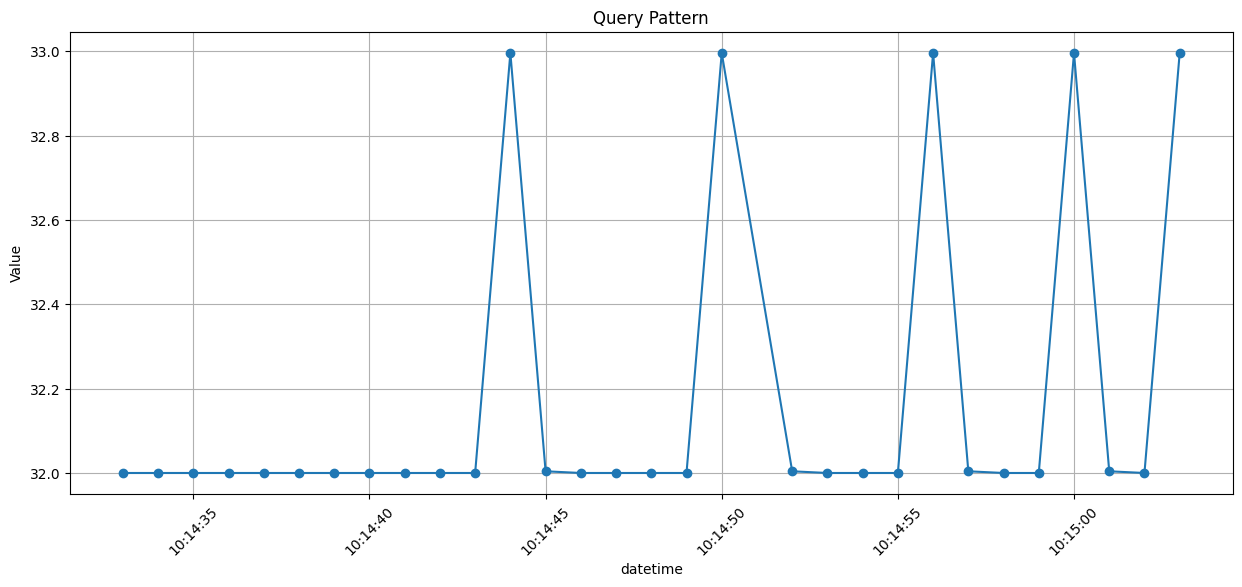

In [7]:
# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == anomTime][
    "vectors"
].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == anomTime]
Q_df = df[(df["datetime"] >= df_query_times.iloc[0]["startTime"]) & (df["datetime"] <= df_query_times.iloc[0]["endTime"])]

# Create a line plot
plot.figure(figsize=(15, 6))
plot.plot(Q_df["datetime"], Q_df["Volume Flow RateRMS"], marker="o", linestyle="-")
plot.xlabel("datetime")
plot.ylabel("Value")
plot.title("Query Pattern")
plot.grid(True)
plot.xticks(rotation=45)  # Rotate x-axis labels for readability

type(query_vector)

In [ ]:
# Filter result_df based on the specific startTime
query_vector = result_df[result_df["startTime"] == anomTime][
    "vectors"
].values.tolist()

## Select historical pattern
df_query_times = result_df[result_df["startTime"] == anomTime]
Q_df = df[(df["datetime"] >= df_query_times.iloc[0]["startTime"]) & (df["datetime"] <= df_query_times.iloc[0]["endTime"])]


result = table1.search(query_vector, n=5)

df1 = df
df2 = result[0]

# Create a list to store the results
result_list = []
# Initialize label counter
label_counter = 1

# Iterate through the rows of df2 to filter df1 and calculate time differences
for index, row in df2.iterrows():
    mask = (df1["datetime"] >= row["startTime"]) & (df1["datetime"] <= row["endTime"])
    filtered_df = df1[mask].copy()  # Create a copy of the filtered DataFrame
    filtered_df["time_difference"] = filtered_df["datetime"] - row["startTime"]
    filtered_df["pattern"] = label_counter
    label_counter += 1  # Increment the label counter
    result_list.append(filtered_df)

# Concatenate the results into a new DataFrame
result_df2 = pd.concat(result_list)

# Group by 'label_counter' and plot each group separately with a legend
groups = result_df2.groupby("pattern")
fig, ax = plot.subplots(figsize=(15, 6))

for name, group in groups:
    ax.plot(
        group["time_difference"], group["Volume Flow RateRMS"], marker="o", label=f"NN {name}"
    )

ax.set_xlabel("Time Difference")
ax.set_ylabel("Sensor Values")
ax.legend(title="Neighbors")
plot.title("Pattern Matches")
plot.grid(False)
plot.show()

In [ ]:
q_res = result[0]
result_list1 = {}
label_counter1=1
df2 = df[['datetime','Volume Flow RateRMS']]

for i in q_res.index:
    mask = (df2['datetime'] >= q_res.loc[i]['startTime']) & (df2['datetime'] <= q_res.loc[i]['endTime'])
    res = df2.loc[mask]
    result_list1[label_counter1] = pd.DataFrame(res)
    label_counter1 +=1

result_list1

    
plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="lightgrey", markersize=12)
plot.plot(df["Volume Flow RateRMS"], color="blue", alpha = 0.5)
plot.plot(Q_df["Volume Flow RateRMS"], color="red", linewidth=7.0, alpha=0.5)

for j in range(2,1+ len(q_res)):
    plot.plot(result_list1[j]["Volume Flow RateRMS"], linewidth=6.0)


plot.show()

## Stumpy comparison

At the core of STUMPY, one can take any time series data and efficiently compute something called a matrix profile, which essentially scans along your entire time series with a fixed window size, m, and finds the exact nearest neighbor for every subsequence within your time series. A matrix profile allows you to determine if there are any conserved behaviors (i.e., conserved subsequences/patterns) within your data and, if so, it can tell you exactly where they are located within your time series

### Install dependencies

In [ ]:
!pip install pandas
!pip install stumpy
!pip install numpy
!pip install matplotlib

In [23]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [11]:
df2 = df[['datetime','Volume Flow RateRMS']]

### Run Stumpy MATCH

In [12]:
m = Q_df["Volume Flow RateRMS"].size
# To set the exclusion zone to zero, set the denominator to np.`inf`
stumpy.config.STUMPY_EXCL_ZONE_DENOM = np.inf

stumpy_matches = stumpy.match(
    Q_df["Volume Flow RateRMS"],
    df2["Volume Flow RateRMS"],
    max_distance=np.inf, # set the threshold to infinity include all subsequences
    max_matches=5,      # find the top 16 matches
)

stumpy.config.STUMPY_EXCL_ZONE_DENOM = 4 # Reset the denominator to its default value

### Visualise matches (1)

In [ ]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(Q_df['Volume Flow RateRMS'].values)

plt.suptitle('Comparing The Query To top five matches', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Volume Flow RateRMS', fontsize='20')
for match_distance, match_idx in stumpy_matches:
    match_z_norm = stumpy.core.z_norm(df2['Volume Flow RateRMS'].values[match_idx:match_idx+len(Q_df)])
    plt.plot(match_z_norm, lw=2)
plt.plot(Q_z_norm, linestyle = "dashed", lw=2, color="black", label="Query Subsequence, Q_df")
plt.legend()
plt.show()

### Visualise matches (2)

In [ ]:
result_list2= {}
label_counter2 = 1

for match_distance, m_id in stumpy_matches:
    match_df = df2[m_id:m_id+len(Q_df)]
    result_list2[label_counter2] = pd.DataFrame(match_df)
    label_counter2 +=1

result_list2

plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="lightgrey", markersize=12)
plot.plot(df["Volume Flow RateRMS"], color="blue", alpha = 0.5)
plot.plot(Q_df["Volume Flow RateRMS"], color="red", linewidth=7.0, alpha=0.5)

for i in range(1, 1 + len(stumpy_matches)):
    plot.plot(result_list2[i]["Volume Flow RateRMS"], linewidth=6.0)

### Extension - exclusion zone
One benefit of using stumpy.match is that, as it discovers each new neighbor, it applies an exclusion zone around it and this ensures that every match that is returned is actually a unique occurrence of your input query. 

### Run stumpy MATCH

In [33]:
m = Q_df["Volume Flow RateRMS"].size
# To set the exclusion zone to zero, set the denominator to np.`inf`
stumpy.config.STUMPY_EXCL_ZONE_DENOM = 40

stumpy_matches = stumpy.match(
    Q_df["Volume Flow RateRMS"],
    df["Volume Flow RateRMS"],
    max_distance=np.inf, # set the threshold to infinity include all subsequences
    max_matches=5,      # find the top 16 matches
)

In [35]:
stumpy_matches


array([[1.2159566666928548e-05, 14610],
       [3.374193248901001, 22260],
       [3.7990567926678693, 22101],
       [3.8870635342009665, 33937],
       [3.9414232004429315, 25712]], dtype=object)

### Visualise matches (1)

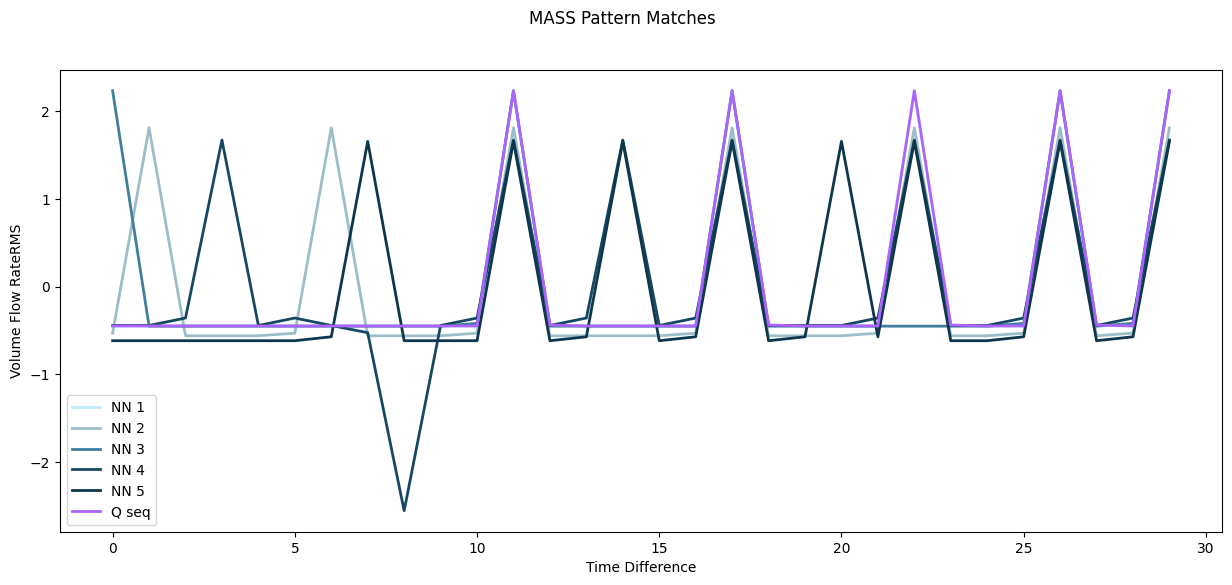

In [40]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(Q_df['Volume Flow RateRMS'].values)

import matplotlib.pyplot as plot

fig, ax = plot.subplots(figsize=(15, 6))

colourlist = ["#C2E9FD", "#9BBEC8", "#427D9D", "#164863", '#0E364C']
ccounter= 0
lcounter = 1

plt.suptitle('MASS Pattern Matches')
plt.xlabel('Time Difference')
plt.ylabel('Volume Flow RateRMS')

for match_distance, match_idx in stumpy_matches:
    match_z_norm = stumpy.core.z_norm(df2['Volume Flow RateRMS'].values[match_idx:match_idx+len(Q_df)])
    plt.plot(match_z_norm, lw=2, color = colourlist[ccounter], label=f"NN {lcounter}")
    ccounter +=1
    lcounter +=1
    
plt.plot(Q_z_norm, lw=2, color="#AD64FF", label="Q seq")
plt.legend()
plt.show()

### Visualise matches (2)

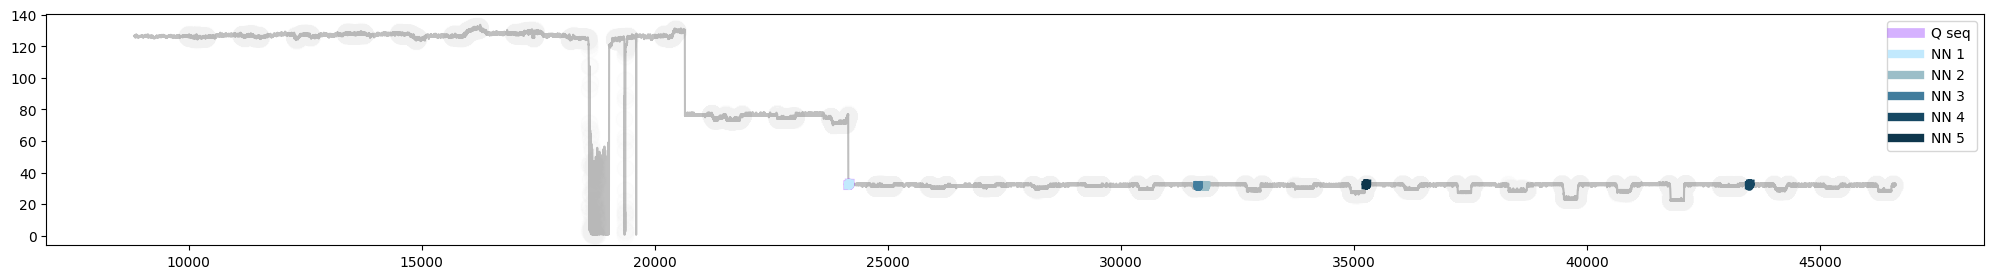

In [39]:
result_list2= {}
label_counter2 = 1

for match_distance, m_id in stumpy_matches:
    match_df = df2[m_id:m_id+len(Q_df)]
    result_list2[label_counter2] = pd.DataFrame(match_df)
    label_counter2 +=1

result_list2

colourlist = ["#C2E9FD", "#9BBEC8", "#427D9D", "#164863", '#0E364C']
ccounter=0
label_counter = 1

plot.figure(figsize=(25, 3))
plot.plot(broken["Volume Flow RateRMS"], linestyle="none", marker="o", color="#F1F1F1", markersize=12, alpha =0.1)
plot.plot(df["Volume Flow RateRMS"], color="grey", alpha = 0.5)
plot.plot(Q_df["Volume Flow RateRMS"], color="#AD64FF", linewidth=7.0, alpha=0.5, label = "Q seq")

for i in range(1, 1 + len(stumpy_matches)):
    plot.plot(result_list2[i]["Volume Flow RateRMS"], color = colourlist[ccounter], linewidth=6.0, label=f"NN {label_counter}")
    ccounter +=1
    label_counter +=1
    
plot.legend()
plt.show()